In [1]:
import numpy as np
import matplotlib.pyplot as plt
from qutip import basis, tensor, sigmax, sigmaz, sigmay, qeye, ptrace, Qobj
from scipy import integrate
from scipy.linalg import lu_factor, lu_solve


In [16]:
# -----------------------
# Parameters
# -----------------------
N = 3             # Total number of spins
J = 1.0            # Interaction strength
h = 1.1            # Field strength in x-direction
g = 0.0            # Field strength in z-direction
beta = 1.0         # Inverse temperature
alpha = 2          # Order of Renyi entropy
tlist = np.linspace(0, 1.8, 25)  # Time grid
steps = 100        # Number of substeps for Crank-Nicolson


In [17]:
# -----------------------
# Renyi Entropy Calculation
# -----------------------
def renyi_entropy(rho, alpha):
    rho_alpha = rho ** alpha
    return (1/(1-alpha)) * np.log(np.real(rho_alpha.tr()))


In [18]:
# -----------------------
# Crank-Nicolson Propagator
# -----------------------
def crank_nicolson_propagator(H: Qobj, t: float, steps: int = 100) -> Qobj:
    dt = t / steps
    dim = H.shape[0]
    I = np.eye(dim, dtype=complex)
    A = I - 1j * (dt/2) * H.full()
    B = I + 1j * (dt/2) * H.full()
    lu, piv = lu_factor(A)
    U_step = lu_solve((lu, piv), B)
    U_total = np.linalg.matrix_power(U_step, steps)
    return Qobj(U_total, dims=H.dims)


In [19]:
# -----------------------
# Hamiltonian Construction
# -----------------------
def spin_chain_ham(h, g, J, N):
    # Build local Pauli operators on each site.
    sx = [tensor([sigmax() if i == j else qeye(2) for i in range(N)]) for j in range(N)]
    sy = [tensor([sigmay() if i == j else qeye(2) for i in range(N)]) for j in range(N)]
    sz = [tensor([sigmaz() if i == j else qeye(2) for i in range(N)]) for j in range(N)]
    H = sum(-J * sz[i] * sz[i+1] for i in range(N-1)) \
        - sum(h * sx[i] for i in range(N)) \
        - sum(g * sz[i] for i in range(N))
    return H


In [20]:
H_full = spin_chain_ham(h, g, J, N)
H_rest = spin_chain_ham(h, g, J, N-1)
# Free (reference) Hamiltonian acting on the full system (here defined on the first spin)
H0 = tensor((-h * sigmax() + -g*sigmaz(), *[qeye(2) for _ in range(N-1)])) + tensor(qeye(2), H_rest)

H_sys = -h * sigmax() - g * sigmaz()


In [21]:
# -----------------------
# Initial State Preparation
# -----------------------
# Thermal state for the bath (N-1 spins):
thermal_state_rest = (-beta * H_rest).expm() / (-beta * H_rest).expm().tr()
# System (first spin) pure state |0><0|
pure_state0 = basis(2, 0) * basis(2, 0).dag()
# Quench operator acting on first spin:
O = tensor(sigmax(), *[qeye(2) for _ in range(N-1)])
# Initial quenched state:
initial_state = O * tensor(pure_state0, thermal_state_rest) * O.dag()

In [22]:
# Define the two-point correlation function.
def twopt(H, psi, A, B, t1, t2):
    U1 = crank_nicolson_propagator(H, t1, steps)
    U2 = crank_nicolson_propagator(H, t2, steps)
    A_t = U1.dag() * A * U1
    B_t = U2.dag() * B * U2
    return (A_t * B_t * psi).tr()

In [23]:
# For the bath operator: H_rest acts on (N-1) spins.
# Define bath_op on the bath Hilbert space (here, acting on the first bath spin):
bath_op = tensor(sigmaz(), *[qeye(2) for _ in range((N-1)-1)])  # dims: 2 x 2^(N-2)


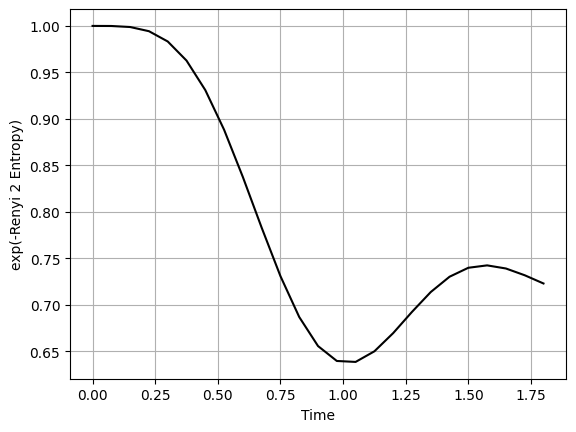

In [24]:
# -----------------------
# State Evolution (Interaction Picture) using Crank-Nicolson
# -----------------------
states = []
for t in tlist:
    U0 = crank_nicolson_propagator(H0, t, steps)
    U_full = crank_nicolson_propagator(H_full, t, steps)
    U_int = U0.dag() * U_full
    states.append(U_int * initial_state * U_int.dag())


renyi_vals = [renyi_entropy(ptrace(state, [0]), alpha) for state in states]
renyi_plot = np.exp(-np.array(renyi_vals))

plt.figure()
plt.plot(tlist, renyi_plot, 'k-', label=f'exp(-Renyi {alpha} Entropy)')
plt.xlabel('Time')
plt.ylabel(f'exp(-Renyi {alpha} Entropy)')
plt.grid(True)
plt.savefig(f"N={N}_TFIM_J={J}_h={h}_g={g}_Renyi_entropy_CN.pdf")
plt.show()

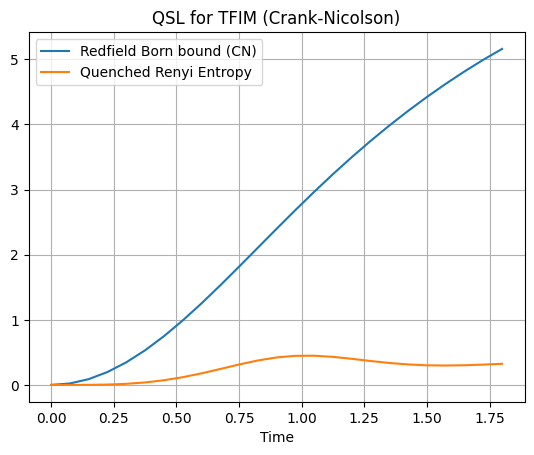

In [25]:
def redfield_bound(t, is_thermal):
    def integrand(t_prime, s):
        if is_thermal:
            bath_state = thermal_state_rest
        else:
            U0 = crank_nicolson_propagator(H0, t_prime, steps)
            U_full = crank_nicolson_propagator(H_full, t_prime, steps)
            U_int = U0.dag() * U_full
            evolved = U_int * initial_state * U_int.dag()
            bath_state = ptrace(evolved, list(range(1, N)))
        corr = np.real(twopt(H_rest, bath_state, bath_op, bath_op, t_prime, s))
        U_sys_t1 = crank_nicolson_propagator(H_sys, t_prime, steps)
        U_sys_t2 = crank_nicolson_propagator(H_sys, s, steps)
        sigz_t1 = U_sys_t1.dag() * sigmaz() * U_sys_t1
        sigz_t2 = U_sys_t2.dag() * sigmaz() * U_sys_t2
        norm1 = np.linalg.norm(sigz_t1.full(), ord='fro')
        norm2 = np.linalg.norm(sigz_t2.full(), ord='fro')
        return 4 * (J**2) * corr * norm1 * norm2
    result, _ = integrate.dblquad(lambda y, x: integrand(y, x), 0, t, lambda x: 0, lambda x: x)
    return result

# Here we compute the thermal ("Born") redfield bound.
#bound = [redfield_bound(t, False) for t in tlist]
born_bound = [redfield_bound(t, True) for t in tlist]

plt.figure()
plt.plot(tlist, born_bound, label='Redfield Born bound (CN)')
plt.plot(tlist, renyi_vals, label='Quenched Renyi Entropy')
plt.xlabel('Time')
plt.title('QSL for TFIM (Crank-Nicolson)')
plt.legend()
plt.grid(True)
plt.show()

In [26]:
# -----------------------
# Liouvillian Spectral Bound Calculation using Crank-Nicolson
# -----------------------
def liouv_superop(t1, t2, is_thermal):
    if is_thermal:
        bath_state = thermal_state_rest
    else:
        U0 = crank_nicolson_propagator(H0, t1, steps)
        U_full = crank_nicolson_propagator(H_full, t1, steps)
        U_int = U0.dag() * U_full
        evolved = U_int * initial_state * U_int.dag()
        bath_state = ptrace(evolved, list(range(1, N)))
    U_sys_t1 = crank_nicolson_propagator(H_sys, t1, steps)
    U_sys_t2 = crank_nicolson_propagator(H_sys, t2, steps)
    sigz_t1 = U_sys_t1.dag() * sigmaz() * U_sys_t1
    sigz_t2 = U_sys_t2.dag() * sigmaz() * U_sys_t2
    bath_corr = twopt(H_rest, bath_state, bath_op, bath_op, t1, t2)
    superop1 = -(J**2) * bath_corr * (tensor(sigz_t1 * sigz_t2, qeye(2)) + tensor(sigz_t2, sigz_t1))
    superop2 = -(J**2) * np.conj(bath_corr) * (tensor(qeye(2), sigz_t2 * sigz_t1) + tensor(sigz_t1, sigz_t2))
    L = superop1 + superop2
    return (L - L.dag()).full()

def redfield_spec_bound(t, is_thermal):
    def inner_integral(y):
        f = lambda x: np.linalg.norm(liouv_superop(y, x, is_thermal), ord=2)
        return integrate.quad(f, 0, y, epsabs=1e-6, epsrel=1e-6)[0]
    return integrate.quad(inner_integral, 0, t, epsabs=1e-6, epsrel=1e-6)[0]




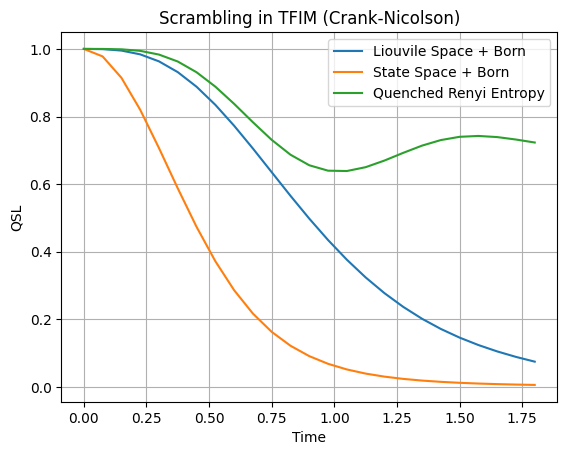

In [27]:
spec_born_bound = [redfield_spec_bound(t, True) for t in tlist]
#spec_bound = [redfield_spec_bound(t, False) for t in tlist]

plt.figure()
#plt.plot(tlist, np.exp(-np.array(bound)), label='State Space')
#plt.plot(tlist, np.exp(-np.array(spec_bound)), label='Liouville Space')
plt.plot(tlist, np.exp(-np.array(spec_born_bound)), label='Liouvile Space + Born')
plt.plot(tlist, np.exp(-np.array(born_bound)), label='State Space + Born')
plt.plot(tlist, renyi_plot, label='Quenched Renyi Entropy')
plt.xlabel('Time')
plt.ylabel('QSL')
plt.title('Scrambling in TFIM (Crank-Nicolson)')
plt.legend()
plt.grid(True)
plt.show()